In [1]:
# Работающая нейросеть

# Импорт
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

In [2]:
# Пути для тренировочных файлов
path1 = r"./har_dataset/train/file.txt"
path2 = r"./har_dataset/train/outfile.txt"
path3 = r"./har_dataset/train/new_train.txt" # Итоговый файл с тренировочными данными

# Пути для тестовых данных
path4 = r"./har_dataset/test/file.txt"
path5 = r"./har_dataset/test/outfile.txt"
path6 = r"./har_dataset/test/new_test.txt" # Итоговый файл с тестовыми данными

# Путь до списка признаков
path_features_file = r"./har_dataset/features.txt"

# Пути к файлам лейблов
path_train_labels = r"./har_dataset/train/y_train.txt"
path_test_labels = r"./har_dataset/test/y_test.txt"
final_train_labels = r"./har_dataset/train/y_train_fin.txt"
final_test_labels = r"./har_dataset/test/y_test_fin.txt"

In [3]:
# Дополнительные функции для обработки файлов

# Функция удаления лишних символов из входного файла
def cleaning_func(path_file, out_path_file, new_path_file):
    fin = open(path_file, 'r')
    fout = open(out_path_file, 'w')
    lines = fin.readlines()
    for line in lines:
        fout.write(line[2:])
    fout.close()
    fin.close()
    fout = open(out_path_file, 'r')
    new = open(new_path_file, 'w')
    lines = fout.readlines()
    for line in lines:
        new.write(" ".join(line.split()) + "\n")
    fout.close()
    new.close()

# Функция, печатающая список признаков из файла 
def features_string(path_features_file):
    features_dict = {}
    with open(path_features_file) as file:
        for line in file:
            key, *value = line.split()
            features_dict[key] = value
    string = ""
    for i in range(1, 562):
        string = string + (features_dict[str(i)])[0] + " "
    return(string)

# Функция уменьшения лейблов
# (переход от системы 1-6 к 0-5 системе)
def labels_decrease(in_lbl, out_lbl):
    f_in = open(in_lbl, 'r')
    f_out = open(out_lbl, 'w')
    lines = f_in.readlines()
    for line in lines:
        f_out.write(str(int(line)-1) + '\n')
    f_out.close()
    f_in.close()

In [22]:
# Вызов функций с аргументами путей до файлов
cleaning_func(path1, path2, path3)
cleaning_func(path4, path5, path6)
print(features_print_func(path_features_file))
labels_decrease(path_train_labels, final_train_labels)
labels_decrease(path_test_labels, final_test_labels)

tBodyAcc-mean()-X tBodyAcc-mean()-Y tBodyAcc-mean()-Z tBodyAcc-std()-X tBodyAcc-std()-Y tBodyAcc-std()-Z tBodyAcc-mad()-X tBodyAcc-mad()-Y tBodyAcc-mad()-Z tBodyAcc-max()-X tBodyAcc-max()-Y tBodyAcc-max()-Z tBodyAcc-min()-X tBodyAcc-min()-Y tBodyAcc-min()-Z tBodyAcc-sma() tBodyAcc-energy()-X tBodyAcc-energy()-Y tBodyAcc-energy()-Z tBodyAcc-iqr()-X tBodyAcc-iqr()-Y tBodyAcc-iqr()-Z tBodyAcc-entropy()-X tBodyAcc-entropy()-Y tBodyAcc-entropy()-Z tBodyAcc-arCoeff()-X,1 tBodyAcc-arCoeff()-X,2 tBodyAcc-arCoeff()-X,3 tBodyAcc-arCoeff()-X,4 tBodyAcc-arCoeff()-Y,1 tBodyAcc-arCoeff()-Y,2 tBodyAcc-arCoeff()-Y,3 tBodyAcc-arCoeff()-Y,4 tBodyAcc-arCoeff()-Z,1 tBodyAcc-arCoeff()-Z,2 tBodyAcc-arCoeff()-Z,3 tBodyAcc-arCoeff()-Z,4 tBodyAcc-correlation()-X,Y tBodyAcc-correlation()-X,Z tBodyAcc-correlation()-Y,Z tGravityAcc-mean()-X tGravityAcc-mean()-Y tGravityAcc-mean()-Z tGravityAcc-std()-X tGravityAcc-std()-Y tGravityAcc-std()-Z tGravityAcc-mad()-X tGravityAcc-mad()-Y tGravityAcc-mad()-Z tGravityAcc-m

In [4]:
# Создание тренировочного и тестового датафреймов
train_dataframe = pd.read_csv(path3, sep=" ")
test_dataframe = pd.read_csv(path6, sep=" ")

# Запись меток из файлов
train_labels = pd.read_csv(final_train_labels, header=None)
test_labels = pd.read_csv(final_test_labels, header=None)

In [5]:
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Создание пайплайнов (из датафреймов в датасет)
batch_size = 32 # Размер пакета
train_ds = df_to_dataset(train_dataframe, train_labels, batch_size=batch_size)
test_ds = df_to_dataset(test_dataframe, test_labels, shuffle=False, batch_size=batch_size)

In [6]:
# Создание списка признаков, если они заданы в файле датасета
for feature_batch, label_batch in train_ds.take(1):
    features = list(feature_batch.keys())

# Создание словаря признаков, если данные хранятся в отдельном файле
features_dict = {}
with open(path_features_file) as file:
    for line in file:
        key, *value = line.split()
        features_dict[key] = value

In [7]:
# Создание слоя признаков
feature_columns = [] # Столбцы признаков
for header in range(0, 561):
    feature_columns.append(feature_column.numeric_column((features[header])))
feature_layer = tf.keras.layers.DenseFeatures(feature_columns) # Слой признаков

In [8]:
# Для теста
example_batch = next(iter(train_ds))[0]
# Служебный метод для создания столбца признаков и преобразования пакета данных
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_column)
    print(feature_layer(example_batch).numpy())
f_test = feature_column.numeric_column("tBodyAcc-mean()-X")
demo(f_test)

NumericColumn(key='tBodyAcc-mean()-X', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0.27296337]
 [0.27346438]
 [0.27752978]
 [0.24910697]
 [0.2711866 ]
 [0.14872362]
 [0.28300244]
 [0.28024137]
 [0.2782633 ]
 [0.25836396]
 [0.3308318 ]
 [0.27466685]
 [0.24445261]
 [0.23489885]
 [0.1561557 ]
 [0.2793797 ]
 [0.27451178]
 [0.25200006]
 [0.24723145]
 [0.2783501 ]
 [0.2748853 ]
 [0.27311456]
 [0.27727452]
 [0.27683604]
 [0.28504223]
 [0.1280471 ]
 [0.22559084]
 [0.35935047]
 [0.271

In [9]:
# Создание модели
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(6, activation=tf.nn.softmax)
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [10]:
# Для сохранения весов модели
checkpoint_path = r"./checkpoint/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# Тренировка модели
history = model.fit(train_ds, validation_data=test_ds, epochs=3, callbacks=[cp_callback])

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

230/230 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8379
Epoch 00001: saving model to ./checkpoint/cp.ckpt
230/230 [==============================] - 115s 498ms/step - loss: 0.4035 - accuracy: 0.8379 - val_loss: 0.2689 - val_accuracy: 0.9016
Epoch 2/3
230/230 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9470
Epoch 00002: saving model to ./checkpoint/cp.ckpt
230/230 [==============================] - 113s 490ms/step - loss: 0.1357 - accurac

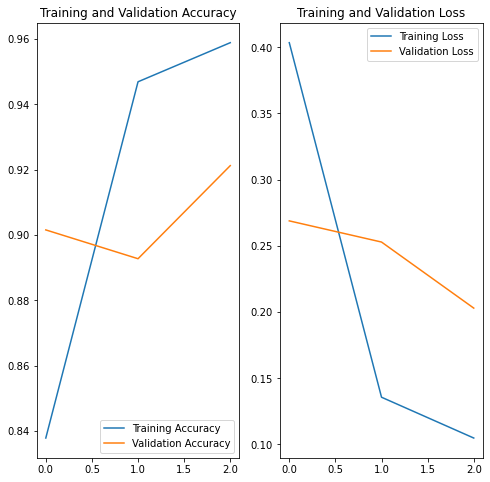

In [11]:
# Визуализация результатов тренировки
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(3)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()